## Data Exploration

In [ ]:

s3_bucket_path="s3://aegovan-data/human_output/human_keyinteractions.json"


In [ ]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)


In [2]:
data_file="input_data.json"


In [ ]:
download_single_file(s3_bucket_path, data_file)

In [3]:

import pandas as pd

data = pd.read_json(data_file)

print("Total number of records: {}".format(data.shape[0]))

Total number of records: 3381


### Sneak preview of the data

In [4]:
#TODO: Fix data format
data["pubmedId"] = data["pubmedId"].astype(str)

In [5]:
data.head(n=3)

,interactionId,interactionType,isNegative,participants,pubmedId,pubmedTitle,pubmedabstract
0,2503510,phosphorylation,false,"[{'uniprotid': 'P43405', 'alias': [['ksyk_huma...",25605870,None,NLRP3 is the most crucial member of the NLR fa...
1,2503513,phosphorylation,false,"[{'uniprotid': 'P43405', 'alias': [['ksyk_huma...",25605870,None,NLRP3 is the most crucial member of the NLR fa...
10,1796163,phosphorylation,false,"[{'uniprotid': 'Q8WUB1', 'alias': [['kc1g2_hum...",25500533,None,"LRRK2, a gene relevant to Parkinson's disease,..."


### Number of interactions per paper
**Note: The number of interactions per paper only takes the filtered interactions extracted from the Intact database**

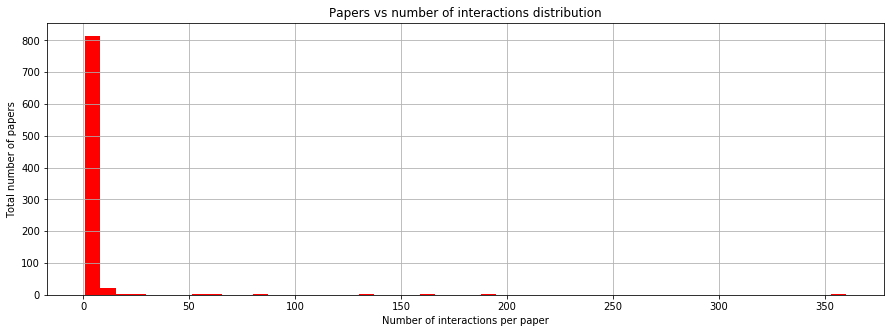

In [8]:
import matplotlib.pyplot as plt

data.pubmedId.value_counts().hist (bins=50, figsize=(15,5), color = 'red')
plt.title('Papers vs number of interactions distribution')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of papers')

plt.show()

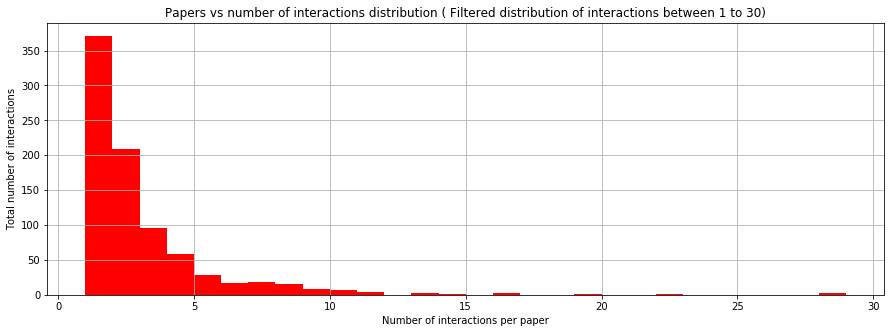

In [9]:
df = data.pubmedId.value_counts().hist (bins=range(1, 30), figsize=(15,5), color = 'red')

plt.title('Papers vs number of interactions distribution ( Filtered distribution of interactions between 1 to 30)')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of interactions')

plt.show()

### Filter out interactions from paper with more than 15 interactions

In [10]:
pubmed_interaction_count = data.pubmedId.value_counts().to_frame().rename(columns={"pubmedId":"interactionCountPerPubmed"})


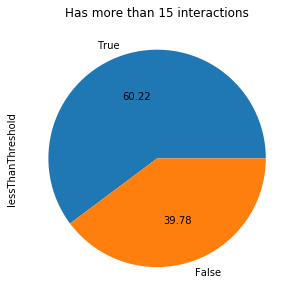

In [11]:
interactions_count= pd.DataFrame()
data["lessThanThreshold"] = data.apply(lambda r: r["pubmedId"] in  pubmed_interaction_count.query('interactionCountPerPubmed <= 15').index , 1)


data.lessThanThreshold.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has more than 15 interactions')
plt.show()

In [12]:
data = data.query("lessThanThreshold == 1")

In [13]:
print("Total number of records after filter: {}".format(data.shape[0]))

Total number of records after filter: 2036


### Interaction Types distribution

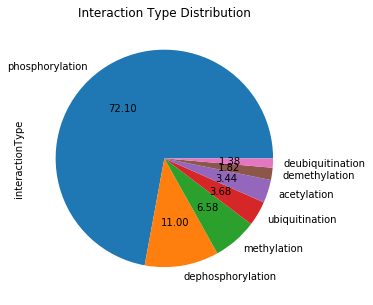

In [14]:
data.interactionType.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Interaction Type Distribution')
plt.show()

In [15]:
data.interactionType.value_counts().to_frame()

,interactionType
phosphorylation,1468
dephosphorylation,224
methylation,134
ubiquitination,75
acetylation,70
demethylation,37
deubiquitination,28


### Distinct interaction types per paper

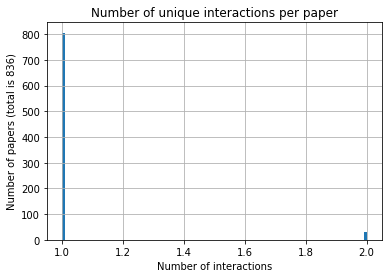

In [16]:
distinct_no_papers = data['pubmedId'].nunique()
data.groupby('pubmedId')['interactionType'].nunique().hist(bins=100)
plt.title("Number of unique interactions per paper")
plt.xlabel('Number of interactions')
plt.ylabel('Number of papers (total is {})'.format(distinct_no_papers))
plt.show()

### Postive vs Negative Relationships

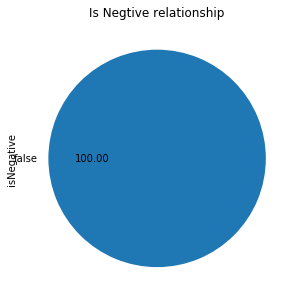

In [17]:
data.isNegative.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Is Negtive relationship')
plt.show()

### Number of participants per interaction

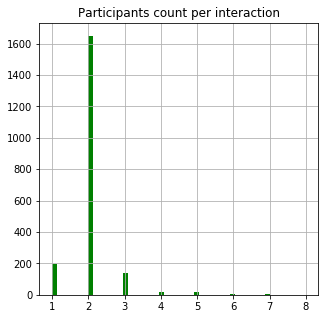

In [18]:
data["participants"].apply(lambda x: len(x)).hist (bins=50, figsize=(5,5), color = 'green')
plt.title("Participants count per interaction")
plt.show()

### Explore if the abstract contains the trigger word

In [19]:
data["hasTriggerWord"] = data.apply(lambda r: r["interactionType"].lower() in r["pubmedabstract"].lower() , 1)

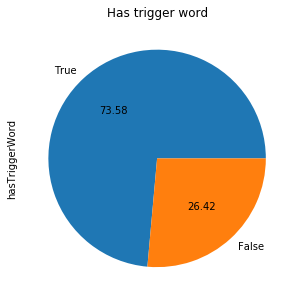

In [20]:
data.hasTriggerWord.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has trigger word')
plt.show()

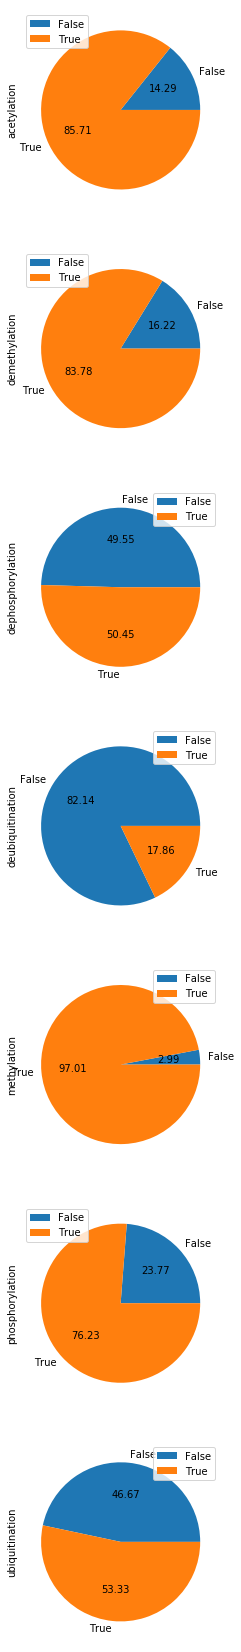

In [21]:
fig, ax = plt.subplots( 7,1, figsize=(45,30))
data.groupby(['hasTriggerWord', 'interactionType']).size().unstack().plot(kind='pie', subplots='True',autopct='%.2f', ax=ax)
plt.show()

### Explore how many of the entity alias are mentioned in the abstract

In [22]:
def getEntityMentionsCount(r):
    count = 0
    abstract = r["pubmedabstract"].lower()
    for p in r["participants"]:
        if p is None or p['alias'] is None : continue
    
        count += len([a for a in p['alias'] if a[0].lower() in abstract])
        
    return count
        

data["entityMentionsCount"] = data.apply(lambda r: getEntityMentionsCount(r)  , 1)

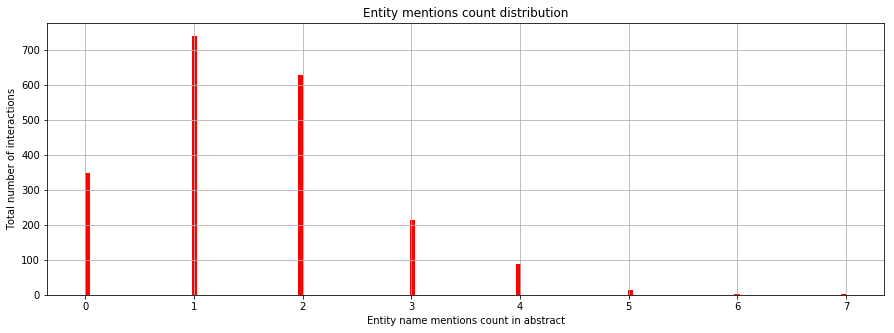

In [23]:
data['entityMentionsCount'].hist ( bins=150, figsize=(15,5), color = 'red')
plt.title('Entity mentions count distribution')
plt.xlabel('Entity name mentions count in abstract')
plt.ylabel('Total number of interactions')

plt.show()

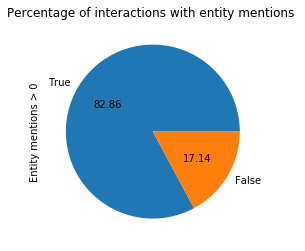

In [24]:
(data['entityMentionsCount'] > 0).value_counts().plot.pie(autopct='%.2f')
plt.title("Percentage of interactions with entity mentions ")
plt.ylabel("Entity mentions > 0")
plt.show()

### Randomly eye ball interactions with no entity mentions

In [25]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

data.query('entityMentionsCount == 0')[['participants','pubmedabstract' ]].sample(n=10)


,participants,pubmedabstract
78,"[{'uniprotid': 'E9PEF3', 'alias': [['scn5a_human'], ['Sodium channel protein type 5 subunit alpha'], ['Sodium channel protein type V subunit alpha'], ['Voltage-gated sodium channel subunit alpha Nav1.5'], ['Sodium channel protein cardiac muscle subunit alpha'], ['HH1'], ['SCN5A']]}, {'uniprotid': 'P11275', 'alias': [['kcc2a_rat'], ['Calcium/calmodulin-dependent protein kinase type II subunit alpha'], ['Camk2a']]}]","The cardiac Na(+) channel Na(V)1.5 current (I(Na)) is critical to cardiac excitability, and altered I(Na) gating has been implicated in genetic and acquired arrhythmias. Ca(2+)/calmodulin-dependent protein kinase II (CaMKII) is up-regulated in heart failure and has been shown to cause I(Na) gating changes that mimic those induced by a point mutation in humans that is associated with combined long QT and Brugada syndromes. We sought to identify the site(s) on Na(V)1.5 that mediate(s) the CaMKII-induced alterations in I(Na) gating. We analyzed both CaMKII binding and CaMKII-dependent phosphorylation of the intracellularly accessible regions of Na(V)1.5 using a series of GST fusion constructs, immobilized peptide arrays, and soluble peptides. A stable interaction between δ(C)-CaMKII and the intracellular loop between domains 1 and 2 of Na(V)1.5 was observed. This region was also phosphorylated by δ(C)-CaMKII, specifically at the Ser-516 and Thr-594 sites. Wild-type (WT) and phosphomutant hNa(V)1.5 were co-expressed with GFP-δ(C)-CaMKII in HEK293 cells, and I(Na) was recorded. As observed in myocytes, CaMKII shifted WT I(Na) availability to a more negative membrane potential and enhanced accumulation of I(Na) into an intermediate inactivated state, but these effects were abolished by mutating either of these sites to non-phosphorylatable Ala residues. Mutation of these sites to phosphomimetic Glu residues negatively shifted I(Na) availability without the need for CaMKII. CaMKII-dependent phosphorylation of Na(V)1.5 at multiple sites (including Thr-594 and Ser-516) appears to be required to evoke loss-of-function changes in gating that could contribute to acquired Brugada syndrome-like effects in heart failure."
3367,"[{'uniprotid': 'Q9Y5B5', 'alias': [['ubp15_human'], ['Ubiquitin carboxyl-terminal hydrolase 15'], ['Unph4'], ['USP15'], ['KIAA0529'], ['Ubiquitin-specific-processing protease 15'], ['Deubiquitinating enzyme 15'], ['Unph-2'], ['Ubiquitin thioesterase 15']]}, {'uniprotid': 'UBIQ_HUMAN', 'alias': [['ubiq_human'], ['UBIQ_HUMAN']]}]","The ubiquitin (Ub)-related modifier Urm1 functions as a sulfur carrier in tRNA thiolation by means of a mechanism that requires the formation of a thiocarboxylate at the C-terminal glycine residue of Urm1. However, whether Urm1 plays an additional role as a Ub-like protein modifier remains unclear. Here, we show that Urm1 is conjugated to lysine residues of target proteins and that oxidative stress enhances protein urmylation in both Saccharomyces cerevisiae and mammalian cells. Similar to ubiquitylation, urmylation involves a thioester intermediate and results in the formation of a covalent peptide bond between Urm1 and its substrates. In contrast to modification by canonical Ub-like modifiers, however, conjugation of Urm1 involves a C-terminal thiocarboxylate of the modifier. We have confirmed that the peroxiredoxin Ahp1 is such a substrate in S. cerevisiae and found that Urm1 targets a specific lysine residue of Ahp1 in vivo. In addition, we have identified several unique substrates in mammalian cells and show that Urm1 targets at least two pathways on oxidant treatment. First, Urm1 is appended to lysine residues of three components that function in its own pathway (i.e., MOCS3, ATPBD3, and CTU2). Second, Urm1 is conjugated to the nucleocytoplasmic shuttling factor cellular apoptosis susceptibility protein. Thus, Urm1 has a conserved dual role by integrating the functions of prokaryotic sulfur carriers with those of eukaryotic protein modifiers 

Okay.. looks like it is only a case of the names of the participants not matching the names of the alias used in the abstract.. 